## Libraries

In [71]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import sklearn
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.ensemble import VotingClassifier
from matplotlib.colors import ListedColormap
import pickle, pyarrow
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

import time

###
---
###

## Reading the Dataset

In [45]:
parquet_df = pd.read_parquet("depression_data.parquet")

In [46]:
df = parquet_df

In [47]:
df.rename(columns={"Chronic Medical Conditions":"Depression"}, inplace=True)

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413768 entries, 0 to 413767
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Name                          413768 non-null  object 
 1   Age                           413768 non-null  int64  
 2   Marital Status                413768 non-null  object 
 3   Education Level               413768 non-null  object 
 4   Number of Children            413768 non-null  int64  
 5   Smoking Status                413768 non-null  object 
 6   Physical Activity Level       413768 non-null  object 
 7   Employment Status             413768 non-null  object 
 8   Income                        413768 non-null  float64
 9   Alcohol Consumption           413768 non-null  object 
 10  Dietary Habits                413768 non-null  object 
 11  Sleep Patterns                413768 non-null  object 
 12  History of Mental Illness     413768 non-nul

###
---
###

In [49]:
df = parquet_df.copy()
df.drop(columns=["Education Level", "Family History of Depression", "Name"], inplace=True)

In [50]:
df["Depression"].replace({"No":0, "Yes":1}, inplace=True)

In [51]:
df["Depression"].value_counts()

Depression
0    277561
1    136207
Name: count, dtype: int64

In [52]:
target = df["Depression"]
frame = df.drop(columns="Depression")

In [53]:
frame.head()

,Age,Marital Status,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse
0,31,Married,2,Non-smoker,Active,Unemployed,26265.67,Moderate,Moderate,Fair,Yes,No
1,55,Married,1,Non-smoker,Sedentary,Employed,42710.36,High,Unhealthy,Fair,Yes,No
2,78,Widowed,1,Non-smoker,Sedentary,Employed,125332.79,Low,Unhealthy,Good,No,No
3,58,Divorced,3,Non-smoker,Moderate,Unemployed,9992.78,Moderate,Moderate,Poor,No,No
4,18,Single,0,Non-smoker,Sedentary,Unemployed,8595.08,Low,Moderate,Fair,Yes,No


###
---
###

In [54]:
x_train, x_test, y_train, y_test = train_test_split(frame, target, test_size=0.05, random_state=5)

In [55]:
x_train.head()

,Age,Marital Status,Number of Children,Smoking Status,Physical Activity Level,Employment Status,Income,Alcohol Consumption,Dietary Habits,Sleep Patterns,History of Mental Illness,History of Substance Abuse
13513,49,Married,1,Current,Moderate,Employed,104852.57,High,Unhealthy,Poor,No,No
324041,59,Married,1,Non-smoker,Sedentary,Employed,24365.22,Moderate,Moderate,Fair,Yes,Yes
144337,78,Married,3,Non-smoker,Moderate,Employed,29327.34,Moderate,Moderate,Fair,No,Yes
250003,43,Married,1,Former,Sedentary,Unemployed,27478.55,High,Moderate,Poor,Yes,No
47584,75,Widowed,2,Former,Moderate,Unemployed,9891.63,High,Unhealthy,Poor,Yes,No


###
---
###

## PipeLine

In [72]:
ordinal_encodings = ColumnTransformer([
    ("enc_somking", OrdinalEncoder(categories=[["Current", "Former", "Non-smoker"]], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [3]),
    ("enc_physical", OrdinalEncoder(categories=[["Sedentary", "Moderate", "Active"]], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [4]),
    ("enc_employment", OrdinalEncoder(categories=[['Unemployed', 'Employed']], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [5]),
    ("enc_alcohol", OrdinalEncoder(categories=[["Low", "Moderate", "High"]], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [7]),
    ("enc_diet", OrdinalEncoder(categories=[["Unhealthy", "Moderate", "Healthy"]], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [8]),
    ("enc_sleep", OrdinalEncoder(categories=[["Poor", "Fair", "Good"]], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [9]),
    ("enc_mental", OrdinalEncoder(categories=[["No", "Yes"]], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [10]),
    ("enc_absue", OrdinalEncoder(categories=[["No", "Yes"]], dtype=int, handle_unknown="use_encoded_value", unknown_value=-1), [11])
], remainder="passthrough")

onehot_encodings = ColumnTransformer([
    ("enc_marry", OneHotEncoder(sparse_output=False, dtype=int, drop="first", handle_unknown="ignore"), [9])
], remainder="passthrough")




minmax_scalers = ColumnTransformer([
    ("scl_age", MinMaxScaler(), [11]),
    ("scl_income", MinMaxScaler(), [13])
], remainder="passthrough")


# model = LogisticRegression(class_weight={0:1 , 1:2})
model =  XGBClassifier()

In [73]:
pipe = Pipeline([
    ("ordinal_encodings", ordinal_encodings),
    ("onehot_encodings", onehot_encodings),
    ("minmax_scalers", minmax_scalers),
    ("model", model)
])

In [74]:
pipe.fit(x_train.values, y_train)

Pipeline(steps=[('ordinal_encodings',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('enc_somking',
                                                  OrdinalEncoder(categories=[['Current',
                                                                              'Former',
                                                                              'Non-smoker']],
                                                                 dtype=<class 'int'>,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  [3]),
                                                 ('enc_physical',
                                                  OrdinalEncoder(categories=[['Sedentary',
                                                                              'Moderate',
                                                                              'Active']],
                                                                 dtype=<class 'int'>,
                                                                 handle...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [75]:
pipe[:-1].get_feature_names_out()

array(['scl_age__remainder__remainder__x0',
       'scl_income__remainder__remainder__x6',
       'remainder__enc_marry__remainder__x1_Married',
       'remainder__enc_marry__remainder__x1_Single',
       'remainder__enc_marry__remainder__x1_Widowed',
       'remainder__remainder__enc_somking__x3',
       'remainder__remainder__enc_physical__x4',
       'remainder__remainder__enc_employment__x5',
       'remainder__remainder__enc_alcohol__x7',
       'remainder__remainder__enc_diet__x8',
       'remainder__remainder__enc_sleep__x9',
       'remainder__remainder__enc_mental__x10',
       'remainder__remainder__enc_absue__x11',
       'remainder__remainder__remainder__x2'], dtype=object)

In [76]:
input_sequence = [
    "Age",
    "Marital Status",
    "Number of Children",
    "Smoking Status",
    "Physical Activity Level"
    "Employment Status",
    "Income",
    "Alcohol Consumption",
    "Dietary Habits",
    "Sleep Patterns",
    "History of Mental Illness",
    "History of Substance Abuse",
]

In [77]:
input1 = [
    21, 
    "Single", 
    0, 
    "Non-smoker", 
    "Sedentary",
    "Unemployed",
    10000,
    "Low",
    "Moderate",
    "Fair",
    "No",
    "No"
]

In [78]:
input2 = [
    24, 
    "Single",
    0,
    "Non-smoker",
    "Sedentary",
    "Unemployed",
    0,
    "Low",
    "Unhealthy",
    "Poor",
    "No",
    "No"
]

In [79]:
pipe.predict([input2])

array([0])

In [80]:
pipe.predict([
  [
    451,
    "Married",
    2,
    "Non-smoker",
    "Moderate",
    "Unemployed",
    45123,
    "Moderate",
    "Healthy",
    "Poor",
    "Yes",
    "Yes"
  ]
])

array([0])

## Depression
### 0 -> No
### 1 -> Yes

In [81]:
def get_metrics(model, x_test, y_test):
    '''
    Parameters:
    ------------------------
    model : ML Model Object i.e., LiniearRegression()
    
    x_test : Featuers Testing DataFrame from train_test_split()
    
    y_test : Target Testing DataFrame from train_test_split()
    
    ________________________
    Returns:
    ------------------------
    subplots(3) : Clasification Report, Confusion Matrix, ROC-AUC Curve


    _____________________________________________________________
    
    '''
    y_pred = model.predict(x_test)
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 8))

    model_name = model if len(str(model)) <= 50 else str(model)[:50]+"...)"
    fig.suptitle(f"\nClassification Metrics for {model_name}\n", fontsize=30)
    
    ##########################################################################################################
    cr = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).T.iloc[:, :3]
    accuracy = round((float(cr.loc["accuracy"][0]))*100, 2)
    t = cr.iloc[[0,1,3,4], :]
    t.loc[["macro avg", "weighted avg"]] = t.loc[["macro avg", "weighted avg"]]*100
    t = round(t, 2)
    
    axes[0].axis('tight')
    axes[0].axis('off')
    t = axes[0].table(cellText=t.values, colLabels=t.columns, rowLabels=t.index, loc="center", cellLoc="center", rowLoc='right', fontsize=5, colColours=['#05C7F2']*3, rowColours=["#BCB7B1"]*4, colWidths=[0.25]*3)
    t.scale(1, 3)
    axes[0].set_title(f"Classification Report\n", fontsize=15)
    axes[0].text(x=-0.018, y=0.035, s=f"Accuracy : {accuracy}%", fontsize=15)
    ##########################################################################################################
    ##########################################################################################################
    ##########################################################################################################
    ##########################################################################################################
    l = np.array(["True Negative", "False Positive", "False Negative", "True Positive"])
    cm = confusion_matrix(y_test, y_pred)
    c = cm.flatten()
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=np.array([f"{i}\n{j:,}" for i, j in zip(l, c)]).reshape(2,2), fmt="", cbar=False, ax=axes[1], cmap = ListedColormap(['#05C7F2']), linewidths = 1, annot_kws = {'size':15})
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            if i != j:  # Check if not diagonal
                # Set cell background to white
                rect = plt.Rectangle((j, i), 1, 1, facecolor='#BCB7B1')
                axes[1].add_patch(rect)
    axes[1].set_xlabel("Predicted Values")
    axes[1].set_ylabel("Actual Values")
    axes[1].axis('tight')
    axes[1].set_title(f"Confusion Matrix\n", fontsize=15)
    ##########################################################################################################
    ##########################################################################################################
    ##########################################################################################################    
    ##########################################################################################################
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    axes[2].plot(fpr, tpr, color='#05C7F2', label=f"ROC-AUC Score\n              {roc_auc_score(y_test, model.predict_proba(x_test)[:,1]):.4f}", fillstyle="full")
    axes[2].plot([0, 1], [0, 1],color='#A19C95', linestyle='dashed')
    axes[2].fill_between(fpr, tpr, alpha=0.5, color='#BCB7B1')
    axes[2].set_xlabel("False Postive Rate")
    axes[2].set_ylabel("True Postive Rate")
    axes[2].legend(loc="upper left")
    axes[2].set_title(f"ROC-AUC Curve\n", fontsize=15)
    ##########################################################################################################
    
    plt.tight_layout()
    plt.show()

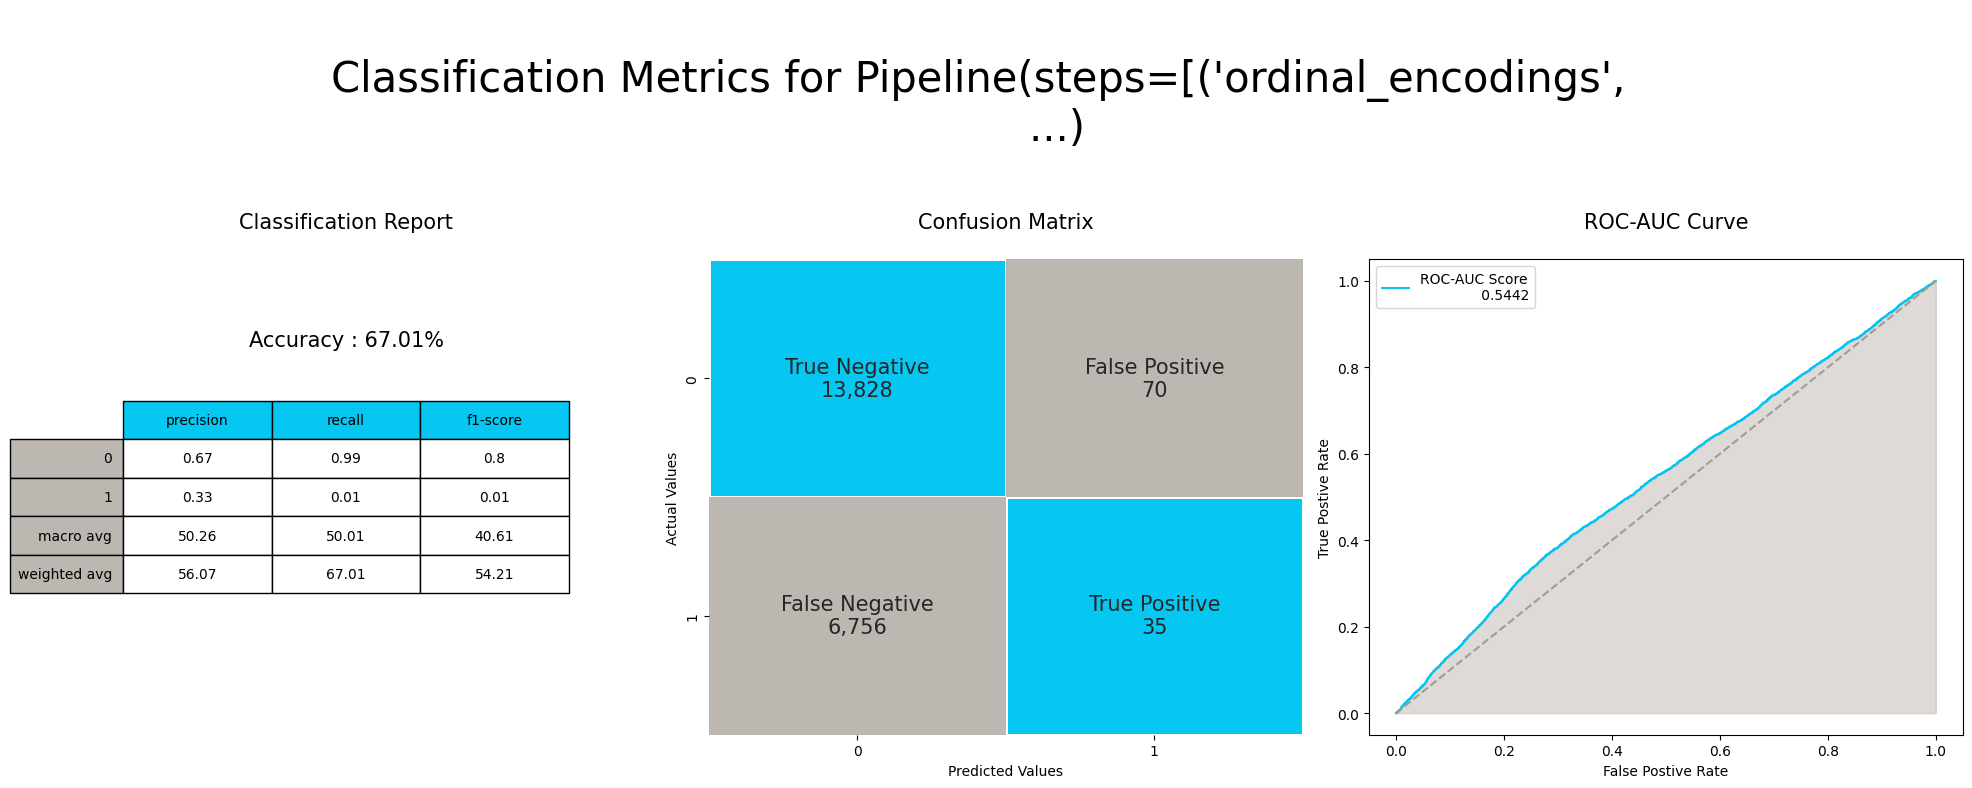

In [82]:
get_metrics(pipe, x_test, y_test)

###
---
###

In [68]:
# pickle.dump(pipe, open(r"Desktop/GL PGPDSE/Capston Project/Depression/DepApp Webapp/pipeline_model.pkl", "wb"))